In [35]:
from hexalattice.hexalattice import create_hex_grid
import numpy as np
import meshio
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import os

output_folder = "simulation_results"
os.makedirs(output_folder, exist_ok=True)

# Parameters for the hexagonal grid
nx, ny = 25, 40  # Number of hexagons in the x and y directions
dx = 1           # Distance between centers of hexagons

# Create hexagonal grid
hex_centers, hex_grid = create_hex_grid(nx=nx, ny=ny, do_plot=False, min_diam=dx)

def get_hex_vertices(center):
    # Get vertices of hexagon with given center
    radius = 2/np.sqrt(3)*dx/2
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 vertices
    vertices = np.column_stack((center[0] + radius * np.cos(angles + np.pi/2),
                                center[1] + radius * np.sin(angles + np.pi/2)))
    return vertices

# Collect all vertices in the grid
hex_vertices_list = []
for center in hex_centers:
    hex_vertices_list.append(get_hex_vertices(center))
hex_vertices_array = np.vstack(hex_vertices_list)

# Ensure unique vertices and reshape cells
unique_vertices, indices = np.unique(hex_vertices_array.round(decimals=6), axis=0, return_inverse=True)
hex_cells = np.reshape(indices, (-1, 6))

# Define unique edges
unique_edges = []
for hexagon in hex_cells:
    for i in range(len(hexagon)):
        node1 = hexagon[i]
        node2 = hexagon[(i + 1) % len(hexagon)]  
        edge = tuple(sorted((node1, node2)))  
        if edge not in unique_edges:
            unique_edges.append(edge)

# Identify boundary nodes and edges
point_ids = np.arange(len(unique_vertices))
boundary_id = np.zeros(len(unique_vertices))

boundary_l, boundary_r, boundary_t, boundary_b = [], [], [], []
for i in point_ids:
    idx = np.where(hex_cells == i)
    if (1 in idx[1] and 5 not in idx[1]) or (2 in idx[1] and 4 not in idx[1]):
        boundary_l.append(i)
    if (5 in idx[1] and 1 not in idx[1]) or (4 in idx[1] and 2 not in idx[1]):
        boundary_r.append(i)
    if (0 in idx[1] and 2 not in idx[1] and 4 not in idx[1]) or (1 in idx[1] and 3 not in idx[1] and 5 in idx[1]):
        boundary_t.append(i)
    if (3 in idx[1] and 1 not in idx[1] and 5 not in idx[1]) or (4 in idx[1] and 0 not in idx[1] and 2 in idx[1]):
        boundary_b.append(i)

boundary_id[np.unique(boundary_t)] = 1
boundary_id[np.unique(boundary_b)] = 2
boundary_id[np.unique(boundary_l)] = 3
boundary_id[np.unique(boundary_r)] = 4

# Identify edges on/connected to boundary
boundary_status = np.zeros(len(unique_edges))
for e in range(len(unique_edges)):
    node1, node2 = unique_edges[e]
    if boundary_id[node1] > 0 and boundary_id[node2] > 0:
        boundary_status[e] = 2
    elif (boundary_id[node1] > 0 and boundary_id[node2] == 0) or (boundary_id[node1] == 0 and boundary_id[node2] > 0):
        boundary_status[e] = 1

# Export to VTK
points = unique_vertices
mesh = meshio.Mesh(points, [("line", unique_edges)], point_data={'Boundary_nodes': boundary_id}, cell_data={'Boundary_edges': [boundary_status]})

output_file_edge = os.path.join(output_folder, "hexagonal_mesh_EDGE.vtk")
meshio.write(output_file_edge, mesh)

# Agent-related constants
At = 10.0         # Fibrotic threshold for cross-sectional area
A0 = 1            # Initial cross-sectional area
epsilon_s = 1.0   # Target strain
beta = 3.0        # Steepness for stiffness Hill function
gamma = 1.0       # Steepness for strain Hill function
w1, w2 = 1, 1.0 # Weights for strain and stiffness contributions
c = 0.5*w1 + w2*(A0 / At) ** beta / ((A0 / At) ** beta + 1)
r = 1.0             # Memory factor
P = 0.2           # Scaling constant for spring constant update
p1 = 0.01         # Probability of new Agent appearing
D_0 = 0.3          # Initial agent density
Dmax = 3

# Initialize Agent Parameters
num_springs = len(unique_edges)
epsilon = np.ones(num_springs)   # Initial strain for each spring
a = np.zeros(num_springs)         # Initial activation level for each spring
D = np.full(num_springs, 0.3)     # Initial agent density for each spring


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

In [36]:
def identify_regions(spring_constants, k_fibrosis, k_normal):
    """
    Identify which springs are inside the stiffened region and which are on the edge.
    Returns two boolean arrays: inside_region, edge_region.
    """
    inside_region = np.zeros(len(spring_constants), dtype=bool)
    edge_region = np.zeros(len(spring_constants), dtype=bool)
    
    # Iterate over each spring
    for spring_index, k_value in enumerate(spring_constants):
        # Identify neighbors of the current spring
        nodes = edges[spring_index]
        connected = np.where((nodes[0] == edges[:, 0]) | 
                             (nodes[0] == edges[:, 1]) | 
                             (nodes[1] == edges[:, 0]) | 
                             (nodes[1] == edges[:, 1]))[0]
        
        neighbor_stiffness = spring_constants[connected]
        
        # If all neighbors are stiff, the spring is inside the stiffened region
        if np.all(neighbor_stiffness >= 30):
            inside_region[spring_index] = True
        # If some neighbors are stiff and some are normal, it's on the edge
        elif np.any(neighbor_stiffness >= 30) and np.any(neighbor_stiffness == 30):
            edge_region[spring_index] = True
    
    return inside_region, edge_region

def compute_strain_and_stress(points, edges, l0, spring_constants):
    """
    Compute strain and stress for each spring based on the current positions.
    Returns two arrays: strain and stress.
    """
    strain = np.zeros(len(edges))
    stress = np.zeros(len(edges))

    for i, edge in enumerate(edges):
        node1, node2 = edge
        p1, p2 = points[node1], points[node2]

        # Calculate current length of the spring
        current_length = np.linalg.norm(p2 - p1)
        
        # Calculate strain and stress
        strain[i] = (current_length - l0) / l0
        stress[i] = spring_constants[i] * strain[i]

    return strain, stress


def compute_spring_force(p1, p2, l0, k):
    current_length = np.linalg.norm(p2 - p1)
    displacement = current_length - l0
    force_magnitude = k * displacement  # Force magnitude based on spring constant

    direction = (p2 - p1) / current_length
    force = force_magnitude * direction
    return force

# Calculate forces on each node from all connected springs
def compute_total_forces(points, edges, l0, spring_constants):
    forces_on_nodes = np.zeros_like(points)
    spring_index = 0

    # Iterate over each spring to compute forces from each connected spring
    for e in edges:
        node1, node2 = e
        p1, p2 = points[node1], points[node2]

        # Compute spring force between the two nodes
        force = compute_spring_force(p1, p2, l0, spring_constants[spring_index])

        # Add the force to the respective nodes
        forces_on_nodes[node1] += force
        forces_on_nodes[node2] -= force  # Opposite force on the other node

        # Move to the next spring
        spring_index += 1

    return forces_on_nodes

# Calculate total energy with variable stiffness
def compute_total_energy(points, edges, l0, spring_constants):
    total_energy = 0.0
    spring_index = 0  # Track the index of the current spring
    for e in edges:
        node1, node2 = e
        p1, p2 = points[node1], points[node2]
        current_length = np.linalg.norm(p2 - p1)
        displacement = current_length - l0
        energy = 0.5 * spring_constants[spring_index] * displacement ** 2
        total_energy += energy
        spring_index += 1
    return total_energy

# Movement and force update (with boundary constraints)
def move_nodes(points, forces, mu, free_nodes):
    new_points = points.copy()
    new_points[free_nodes] += mu * forces[free_nodes]
    return new_points

# Remove specified edges and corresponding spring constants
def remove_edge(edges, points, spring_constants, removed_id):
    point_ids = np.arange(len(points))
    
    # Step 1: Remove edges that should be removed
    for i in removed_id:
        edges = np.delete(edges, i, axis=0)
        spring_constants = np.delete(spring_constants, i, axis=0)

    # Step 2: Remove edges that have become disconnected after Step 1
    for i in point_ids:
        idx = np.where(edges == i)
        n_of_edges = len(idx[0])

        if n_of_edges==1:
            edges = np.delete(edges, idx[0], axis=0)
            spring_constants = np.delete(spring_constants, idx[0], axis=0)

    return edges, spring_constants

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Functions for agent-specific updates
# Stiffness-based activation
def calc_aK(A, At, beta):
    return (A / At) ** beta / ((A / At) ** beta + 1)

# Strain-based activation
def calc_aepsilon(epsilon, epsilon_s, gamma):
    return (epsilon / epsilon_s) ** gamma / ((epsilon / epsilon_s) ** gamma + 1)

# Update the activation with memory effect
def update_activation(a, a_epsilon, a_K, w1, w2, c, r):
    #return a * (1 - r) + r * (w1 * a_epsilon + w2 * a_K)
    return a * (1 - r) + r * (w1*a_epsilon + w2*a_K - c)

# Update agent density
def update_agent_density(D, a, p1, n, s, D_0, Dmax, w2):
    X = Dmax/D_0
    p2 = p1*n/(s*D_0)
    p3 = (p2 * (1 - (1/X))) / (w2 - 0.5)

    return D + (p1 * n / s) + (p3 * a - p2) * D

# Update spring constants based on activation level
def update_spring_constant(spring_constants, a, D, P, inside_region, soften_rate, k_normal):
    """
    Update spring constants:
    - Soften springs inside stiffened regions, but keep them greater than k_normal.
    - Standard stiffening for other springs.
    """
    new_spring_constants = spring_constants.copy()
    
    for i in range(len(a)):
        if inside_region[i]:
            # Soften springs inside the stiffened region, but ensure it's not lower than k_normal
            new_spring_constants[i] = max(spring_constants[i] - soften_rate, k_normal)
        else:
            # Standard stiffening
            new_spring_constants[i] += P * a[i] * D[i]

    return new_spring_constants

def plot_energy(energy):

    plt.plot(energy)

    plt.xlabel("Number of iterations")
    plt.ylabel("Total energy")

    plt.show()
    plt.clf()

In [37]:

def simulate(points, edges, l0, spring_constants, mu, T, tolerance, max_iterations, free_nodes, plot_bar = True, print_results=True, energy_plot=True):

    if plot_bar:
        progress_bar = tqdm(total=max_iterations, desc="Simulation Progress")
    consecutive_small_changes = 0
    iteration = 0
    previous_energy = compute_total_energy(points, edges, l0, spring_constants)
    delta_energy = 10        # init value

    stagnation = False
    stagnation_counter = 0

    energy = []

    while (iteration < max_iterations) and stagnation==False:
        # Calculate total forces on each node
        forces_on_nodes = compute_total_forces(points, edges, l0, spring_constants)

        # Move nodes according to the forces, but do not move the fixed nodes
        new_points = move_nodes(points, forces_on_nodes, mu, free_nodes)

        # Calculate total energy after moving nodes
        new_energy = compute_total_energy(new_points, edges, l0, spring_constants)
        

        # Compare energies
        energy.append(new_energy)
        delta_energy = new_energy - previous_energy
        relative_energy_change = abs(delta_energy) / abs(new_energy)

        if relative_energy_change < tolerance:
            stagnation_counter = stagnation_counter +1
        else:
            stagnation_counter = 0

        if stagnation_counter >=20:
            stagnation = True

        # Acceptance criteria
        if delta_energy < 0:
            # Energy decreased, accept the new configuration
            points = new_points
            previous_energy = new_energy
            mu = mu*1.1
            P =0
        else:
            P = np.exp(-delta_energy / T)
            # Energy increased, accept with probability P = exp(-2 * delta_energy / T)
            if np.random.random() < P:
                # Accept the configuration with probability P
                points = new_points
                previous_energy = new_energy
            else:
                # Reject the configuration
                mu = mu * 0.9

        T = T *0.99

        iteration += 1
        if plot_bar:
            progress_bar.update(1)

        if print_results:
            if iteration==1 or iteration%250 == 0:
                print(f"Iteration {iteration}, mu: {mu}, T: {T}, P = {P}")
                print(f"New energy: {new_energy}")
                print("Energy change: ", delta_energy)
                print("Number of edges: ", len(edges))
                print()

    if energy_plot:
        plot_energy(energy)

    return points, edges, spring_constants

Pre-converged state


Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 1, mu: 0.011000000000000001, T: 0.995, P = 0
New energy: 9057.310225660038
Energy change:  -1703.6294871107348
Number of edges:  3129

Iteration 250, mu: 0.003905456423500684, T: 0.285607880564032, P = 1.3836061926237722e-11
New energy: 5291.398307480989
Energy change:  7.177151731404592
Number of edges:  3129

Iteration 500, mu: 0.004118410817417048, T: 0.08157186144027828, P = 0
New energy: 4945.188191818722
Energy change:  -2.8666377255067346
Number of edges:  3129

Iteration 750, mu: 0.004342977061260973, T: 0.023297566459620722, P = 0
New energy: 4781.21965185542
Energy change:  -0.3694646382773499
Number of edges:  3129

Iteration 1000, mu: 0.004121809487141332, T: 0.006653968578831948, P = 0
New energy: 4683.182612768423
Energy change:  -0.46458949801217386
Number of edges:  3129

Iteration 1250, mu: 0.003911904946455209, T: 0.0019004258631398548, P = 0
New energy: 4611.7348438554445
Energy change:  -0.7732051021021107
Number of edges:  3129

Iteration 1500, mu: 0.0037

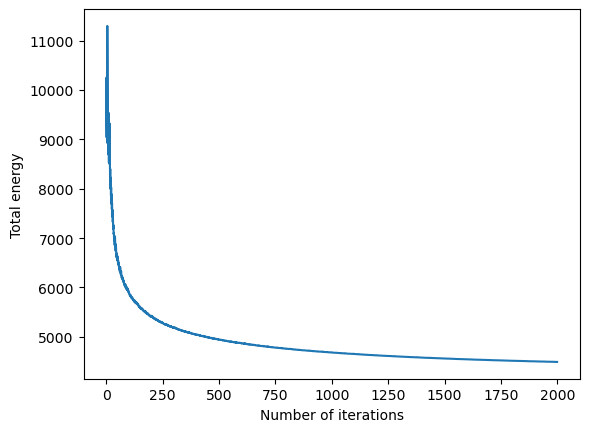

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.


Agent-based simulation
Phase :  0
  D max :  0.3062233942357918
  Strain :  0.43681687440076694
  a :  0.22119647247562724
  a_K :  0.568734237957632
  Stiffness    mean : 56.94275754018567


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation completed in 71.18 seconds.


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

<Figure size 640x480 with 0 Axes>

In [38]:
# Load the mesh from the previous steps
# mesh = meshio.read("hexagonal_mesh.vtk")  # Optional: Load if needed
mesh_EDGE = meshio.read("hexagonal_mesh_EDGE.vtk")  # Load edges from VTK file

# Extract the points and edges
points = mesh_EDGE.points[:, :2]  # Use only x, y coordinates for 2D
edges = mesh_EDGE.cells_dict['line']
boundary_node_ids = mesh_EDGE.point_data['Boundary_nodes']
boundary_edge_ids = mesh_EDGE.cell_data['Boundary_edges'][0]

# Parameters for simulation
k_normal = 1.0  # Normal spring constant
k_fibrosis = 100 * k_normal  # Increased stiffness for fibrosis
l0 = 0.4 * (2 / np.sqrt(3) * dx / 2)  # Rest length of the springs
mu = 0.01  # Initial value of step size
T = 1.0  # Initial temperature
alpha = 0.55  # Portion of springs that are stiffened
max_iterations = 800  # Max iterations
tolerance = 1e-7  # Convergence tolerance for relative energy change
walk_length = 600
soften_rate = 1
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Set initial spring constants
spring_constants = np.full(len(edges), k_normal)  # All springs start with normal stiffness

# Free nodes (not on boundary)
free_nodes = np.where(boundary_node_ids == 0)

# Start timing the simulation
start_time = time.time()

# Run the random walk for fibrosis initialization
healthy_ids = np.where((spring_constants == k_normal))[0]
while len(healthy_ids)/len(edges)>1-alpha:
    # Choose seeds of new fibrotic region
    #feasible_ids = np.where((spring_constants==k_normal)&(boundary_edge_ids == 1 ))[0]
    feasible_ids = np.where(spring_constants==k_normal)[0]
    new_stiff = np.random.choice(feasible_ids)
    spring_constants[new_stiff] = k_fibrosis

    # Do random walk (spread fibrosis), N = 100
    for i in range(walk_length):
        nodes = edges[new_stiff]
        connected = np.where((nodes[0] == edges[:,0]) | (nodes[0] == edges[:,1]) | (nodes[1] == edges[:,0]) | (nodes[1] == edges[:,1]))
        new_stiff = np.random.choice(connected[0])
        spring_constants[new_stiff] = k_fibrosis

    # Update
    healthy_ids = np.where((spring_constants==k_normal))[0]

total_energy_history = []
spring_constant_history = []

#pre-converge step
print("Pre-converged state")
pre_convergence_iterations = 2000
final_positions, final_edges, final_spring_constants = simulate(
    points, edges, l0, spring_constants, mu, T, tolerance, pre_convergence_iterations, free_nodes)

points = final_positions
edges = final_edges
spring_constants = final_spring_constants

strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
meshio.write("hexagonal_mesh_final_result_EDGE_init.vtk", 
    meshio.Mesh(final_positions, cells=[("line", final_edges)], cell_data={'Stiffness': [spring_constants],"Strain": [strain],"Stress": [stress]}))

#Simulation with agent
print("Agent-based simulation")
agent_update_interval = 500
agent_total_iterations = 100  # Total iterations in agent-driven phase
activation_history = []
agent_density_history = []
stiffness_history = []
epsilon_history = []

for phase in range(0, agent_total_iterations):
    
    # Update the agent density and activation here based on the new state of the system
    #epsilon = (A0*epsilon_s)/spring_constants # + epsilon (I'm not sure about this)
    epsilon, stress = compute_strain_and_stress(points, edges, l0, spring_constants)

    a_K = calc_aK(spring_constants, At, beta)
    a_epsilon = calc_aepsilon(epsilon, epsilon_s, gamma)
    a = update_activation(a, a_epsilon, a_K, w1, w2, c, r)

    inside_region, edge_region = identify_regions(spring_constants, k_fibrosis, k_normal)

    spring_constants = update_spring_constant(spring_constants, a, D, P, inside_region, soften_rate, k_normal)


    D = update_agent_density(D, a, p1, len(points), len(edges), D_0, Dmax, w2)
    D = np.clip(D, D_0, Dmax)  # Bound the agent density

    # Track the mean activation and agent density for plotting
    activation_history.append(np.mean(a))
    agent_density_history.append(np.mean(D))
    stiffness_history.append(np.mean(spring_constants))
    epsilon_history.append(np.mean(epsilon))

    # Run the simulation for the interval period
    final_positions, edges, spring_constants = simulate(
        points, edges, l0, spring_constants, mu, T, tolerance, agent_update_interval, free_nodes, False, False, False)
    
    strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
    # Update points based on new positions
    points = final_positions
    
    if phase%2==0:
        print("Phase : ", phase)
        # print("  a max : ", np.max(a),", min : ", np.min(a))
        print("  D max : ", np.max(D))
        print("  Strain : ", np.mean(epsilon))
        print("  a : ", np.mean(a_epsilon))
        print("  a_K : ", + np.mean(a_K))
        print("  Stiffness    mean :", np.mean(spring_constants))

        filename = os.path.join(output_folder, f"hexagonal_mesh_final_result_EDGE_agent_{str(phase).zfill(4)}.vtk")
        meshio.write(
            filename,
            meshio.Mesh(
                final_positions,
                cells=[("line", final_edges)],
                cell_data={
                    "Stiffness": [spring_constants],
                    "Strain": [strain],
                    "Stress": [stress]
                }
            )
        )

# Measure elapsed time
elapsed_time = time.time() - start_time
print(f"Simulation completed in {elapsed_time:.2f} seconds.")

strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
filename = os.path.join(output_folder, f"hexagonal_mesh_final_result_EDGE.vtk")
meshio.write(
            filename,
            meshio.Mesh(
                final_positions,
                cells=[("line", final_edges)],
                cell_data={
                    "Stiffness": [spring_constants],
                    "Strain": [strain],
                    "Stress": [stress]
                }
            )
        )


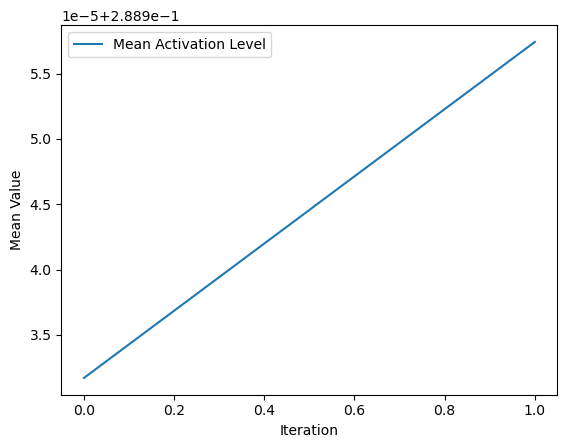

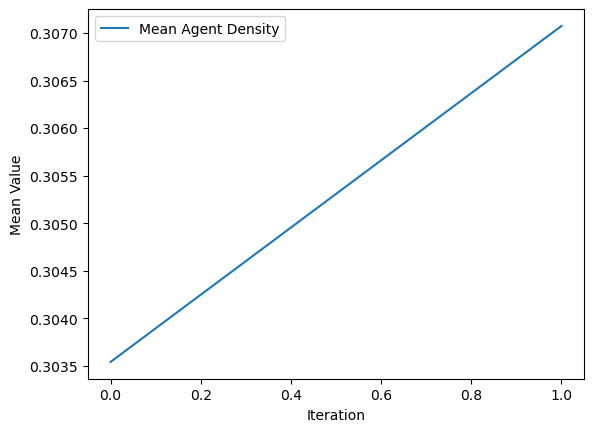

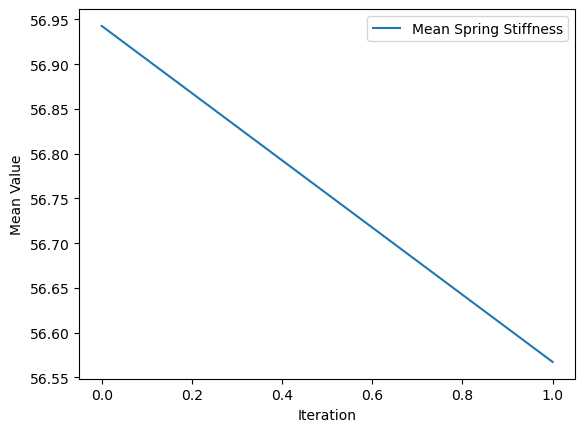

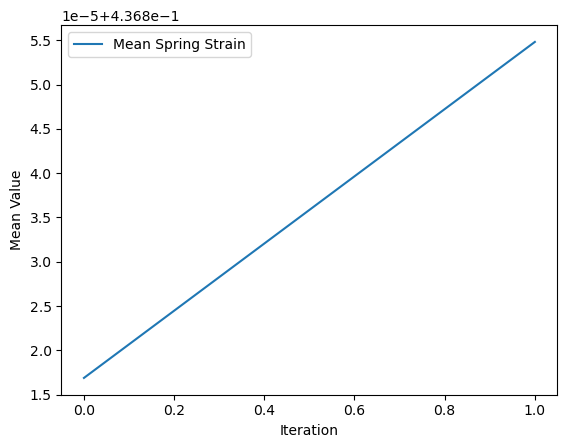

In [39]:
# Plotting the results after both phases
plt.figure()
plt.plot(activation_history, label='Mean Activation Level')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

plt.figure()
plt.plot(agent_density_history, label='Mean Agent Density')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plotting the results after both phases
plt.figure()
plt.plot(stiffness_history, label='Mean Spring Stiffness')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plotting the results after both phases
plt.figure()
plt.plot(epsilon_history, label='Mean Spring Strain')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()


Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

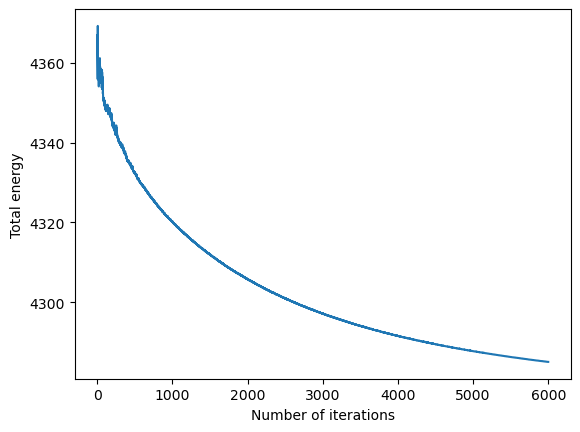

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

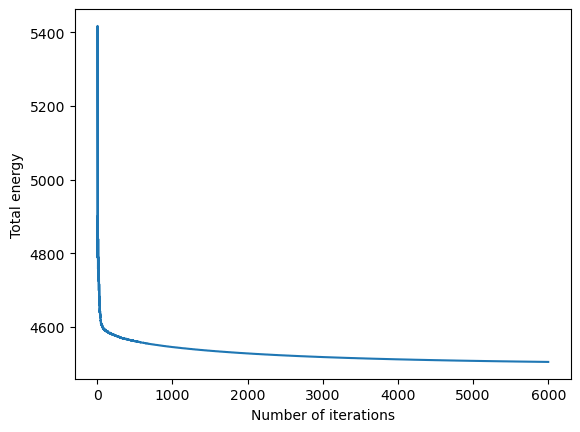

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

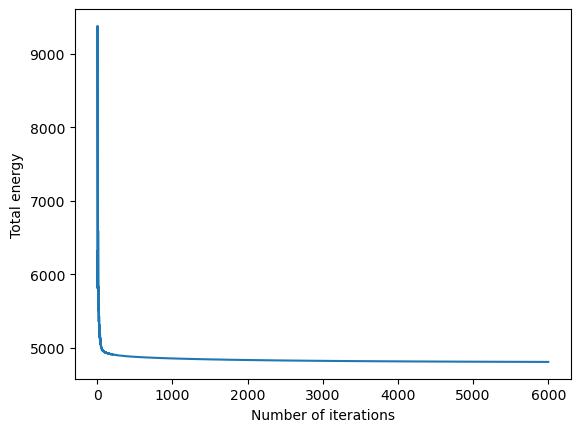

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

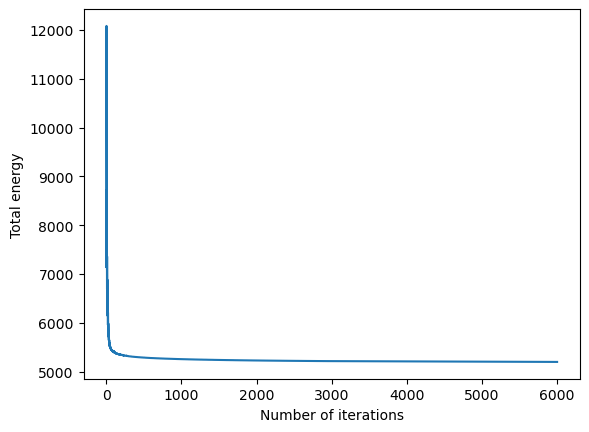

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

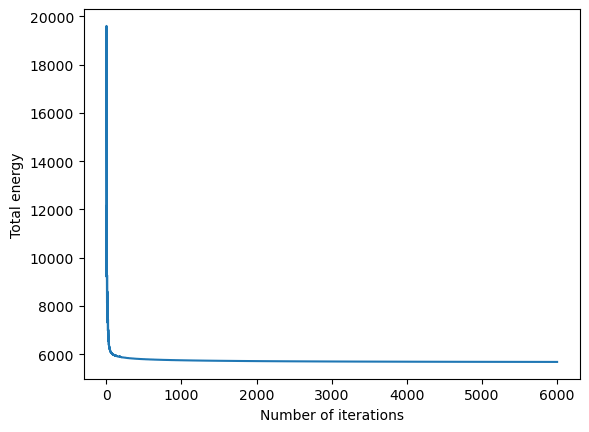

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

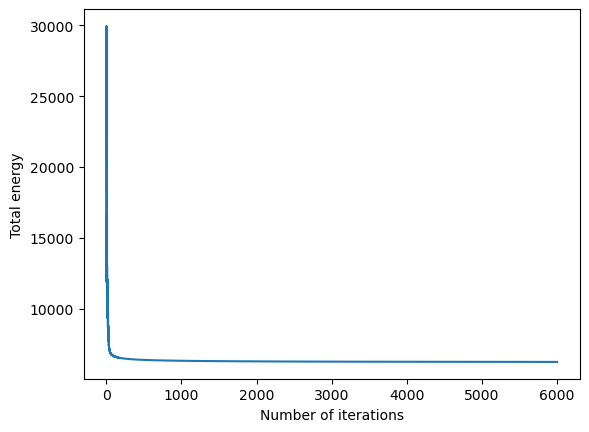

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

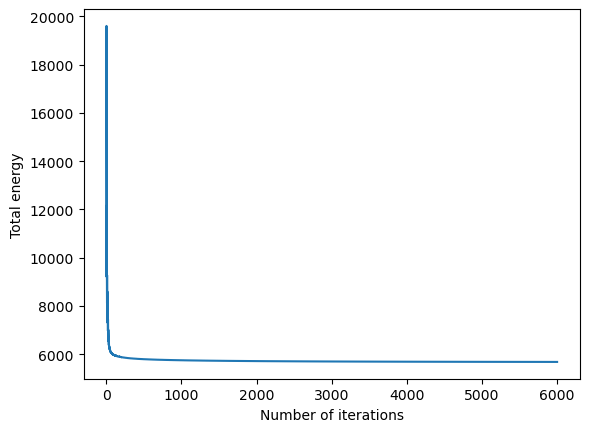

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

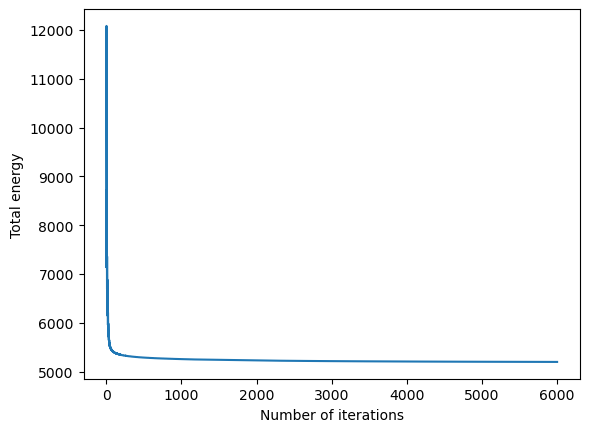

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

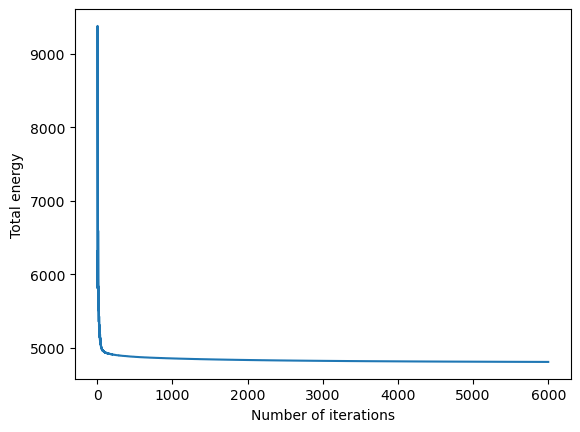

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Simulation Progress:   0%|          | 0/6000 [00:00<?, ?it/s]

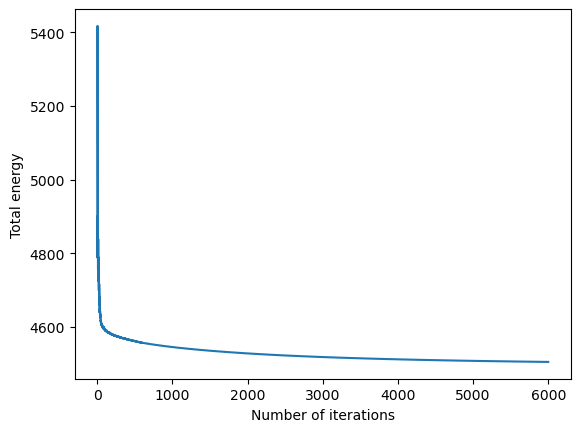

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

<Figure size 640x480 with 0 Axes>

In [40]:

# Parameters for breathing cycle
breathing_cycles = 0           # Number of full breathing cycles (inhalation + exhalation)
steps_per_cycle = 5           # Number of steps for each inhalation/exhalation phase
boundary_displacement = 0.15   # 15% movement for the bottom boundary
initial_positions = points.copy()  # Store the initial positions of the mesh
cycle_iterations = 6000
# Identify bottom boundary nodes
bottom_boundary_nodes = np.where(boundary_node_ids == 2)[0]  # Assuming bottom boundary is labeled with 2
bottom_y_position = np.mean(points[bottom_boundary_nodes, 1])  # Get the average y-position of bottom nodes
displacement_amplitude = boundary_displacement * bottom_y_position  # 15% of the bottom y-position

def simulate_breathing_cycle(points, edges, l0, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes):
    output_folder = "simulation_results"
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

    cycle_data = []  # To store the strain and stress for each export
    for cycle in range(breathing_cycles):
        for step in range(steps_per_cycle):
            # Calculate the incremental displacement for this step
            displacement_step = displacement_amplitude * (step / steps_per_cycle)

            # Move bottom boundary nodes for inhalation
            points[bottom_boundary_nodes, 1] = initial_positions[bottom_boundary_nodes, 1] + displacement_step

            # Run the simulation for this step
            final_positions, final_edges, final_spring_constants = simulate(
                points, edges, l0, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes, plot_bar=True, print_results=False
            )

            # Calculate strain and stress
            strain, stress = compute_strain_and_stress(final_positions, edges, l0, final_spring_constants)

            # Export the mesh with strain and stress data
            filename = os.path.join(output_folder, f"hexagonal_mesh_cycle_{cycle+1}_step_{step+1}.vtk")
            meshio.write(
                filename,
                meshio.Mesh(
                    final_positions,
                    cells=[("line", final_edges)],
                    cell_data={
                        "Stiffness": [final_spring_constants],
                        "Strain": [strain],
                        "Stress": [stress]
                    }
                )
            )
            cycle_data.append({"cycle": cycle + 1, "step": step + 1, "strain": strain, "stress": stress})

        # Exhalation phase: return bottom boundary nodes to initial position
        for step in range(steps_per_cycle):
            displacement_step = displacement_amplitude * (1 - step / steps_per_cycle)
            points[bottom_boundary_nodes, 1] = initial_positions[bottom_boundary_nodes, 1] + displacement_step

            final_positions, final_edges, final_spring_constants = simulate(
                points, edges, l0, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes, plot_bar=True, print_results=False
            )

            # Calculate strain and stress
            strain, stress = compute_strain_and_stress(final_positions, edges, l0, final_spring_constants)

            # Export the mesh with strain and stress data
            filename = os.path.join(output_folder, f"hexagonal_mesh_cycle_{cycle+1}_step_{step+1 + steps_per_cycle}.vtk")
            meshio.write(
                filename,
                meshio.Mesh(
                    final_positions,
                    cells=[("line", final_edges)],
                    cell_data={
                        "Stiffness": [final_spring_constants],
                        "Strain": [strain],
                        "Stress": [stress]
                    }
                )
            )
            cycle_data.append({"cycle": cycle + 1, "step": step + 1 + steps_per_cycle, "strain": strain, "stress": stress})

    return cycle_data

# Run the breathing cycle simulation
breathing_data = simulate_breathing_cycle(points, edges, l0, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes)